# Fine Tune GPT-2 on tech-tutorials scraped from the Internet
## Pieces of code were borrowed from the following public repositories and tutorials:
### https://mccormickml.com/2019/07/22/BERT-fine-tuning/
### https://snappishproductions.com/blog/2020/03/01/chapter-9-text-generation-with-gpt-2-and-only-pytorch.html.html
### Hugging Face Language model fine-tuning script https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning
### Rey Farhan: Easy GPT2 fine-tuning with Hugging Face and PyTorch https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=EKOTlwcmxmej

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 5.3MB/s 
     |████████████████████████████████| 3.3MB 22.0MB/s 
     |████████████████████████████████| 901kB 42.1MB/s 


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

torch.manual_seed(42)


# Clear any logs from previous runs
!rm -rf ./logs/

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config
from transformers import AdamW, Adafactor
from transformers import get_polynomial_decay_schedule_with_warmup, get_linear_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup, get_cosine_schedule_with_warmup, get_constant_schedule_with_warmup, get_constant_schedule, get_scheduler  
from transformers.optimization import AdafactorSchedule


In [ ]:
from pathlib import Path

# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'")
filename = 'all_data.csv'


drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!nvidia-smi

Tue Jul  6 06:21:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [ ]:
# load into a data frame
df = pd.read_csv(filename, error_bad_lines=False) 
df.dropna(inplace=True)
df

,title,article_body
0,Whetting Your Appetite,"If you do much work on computers, eventually y..."
1,Using the Python Interpreter,The Python interpreter is usually installed as...
2,More Control Flow Tools,"Besides the , statement just introduced, Pytho..."
3,The Python Language Reference,This reference manual describes the syntax and...
4,The Python Tutorial,"Python is an easy to learn, powerful programmi..."
...,...,...
1287,HTML,Images can improve the design and the appearan...
1289,HTML,"HTML links can be used to create bookmarks, so..."
1290,HTML,An HTML link is displayed in a different color...
1291,HTML,"An HTML element is defined by a start tag, som..."


In [ ]:
articles = df.article_body.copy()
articles

0       If you do much work on computers, eventually y...
1       The Python interpreter is usually installed as...
2       Besides the , statement just introduced, Pytho...
3       This reference manual describes the syntax and...
4       Python is an easy to learn, powerful programmi...
                              ...                        
1287    Images can improve the design and the appearan...
1289    HTML links can be used to create bookmarks, so...
1290    An HTML link is displayed in a different color...
1291    An HTML element is defined by a start tag, som...
1297    In this chapter we will show some basic HTML e...
Name: article_body, Length: 573, dtype: object

In [ ]:
# Load the GPT tokenizer.

from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>') 
                                          
                                          
                                          
                                          
                                          
                                          #gpt2-medium





#tokenizer = GPT2Tokenizer.from_pretrained('gpt2') #gpt2-medium
# unk_token = '<|endoftext|>', errors='replace'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. 

batch_size = 2

In [ ]:
# I'm using the standard PyTorch approach of loading data in using a dataset class.
# I'm passing in the tokenizer as an argument but normally I would instantiate it within the class.

class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(articles, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  515 training samples
   58 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


Finetune GPT2 Language Model

In [ ]:

configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model.cpu()
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# params that proven to be working best

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon,
                  
                )

In [ ]:
# # # Adafactor From Transformers Library
# # optimizer = Adafactor(model.parameters(),
# #                   lr = None,
# #                   eps=(1e-30, 1e-3),
# #                   clip_threshold=1.0,
# #                   decay_rate=-0.8,
# #                   beta1=None,
# #                   weight_decay=0.0,
# #                   scale_parameter=True,
# #                   relative_step=True,
# #                   warmup_init=True,
                  
# #                 )


# optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs



In [ ]:
type(warmup_steps)

float

In [ ]:
# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)


In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    258. Loss: 2.6897921562194824.   Elapsed: 0:01:50.
0:  bipartisanIn our future, we people may continue to have access to the commonwealth of the United people." The words will remain in the standard "Constitution",,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    258. Loss: 1.188781499862671.   Elapsed: 0:03:44.
0:  increasingThe list of our favorite movies, plays and plays related to music and books, and their links include links to the associated videos.,The list of our favorite movies, plays and plays related to music and books, and their links include link links to the associated videos.,The list of our favorite movies, plays and plays related to video and movies, and their links include links to the corresponding videos.,The list of our favorite movies, plays and plays related to video and movies, and their links include links to our associated videos.,The list of our favorite movies, plays and plays related to music, and their links include links to the corresponding videos. This list also includes links to the official soundtrack, movie audio and music videos, and the related videos.,This list also includes links to the official soundtrack, movie audio and music videos, and the related videos.,

  Average training lo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    258. Loss: 2.6381218433380127.   Elapsed: 0:01:49.
0: dayLaptop: The simplest and most direct way to find out where your system is located is to use a browser 
, which can be downloaded, or by using an Internet service.,To start with,,.,A good place to start with an internet script is as
your first internet script:,Get certified,by completing,a course today!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    258. Loss: 1.955784559249878.   Elapsed: 0:03:40.
0:  HangThe CSS property set in the, property sets the font-size of an element.,Following is the CSS property set in the, property sets the font-family of an element.,Following is the CSS property set in the, property sets the font-size of an element.,Following is the CSS property set in the, property sets the font-family of an element.,Following is the CSS property set in the, property sets the font-size of an element.,To set a font size for the element, add an 
, property:,Add the, property to the, property:,Add the, property to the, property:,To set the font-family of an element, add a, property:,Add the, property to the, property:,Get certified,by completing,a course today!

  Average training loss: 1.13
  Training epoch took: 0:04:47

Running Validation...
  Validation Loss: 0.98
  Validation took: 0:00:10

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    258. Loss: 0.5711275935173035.   Elapsed: 0:01:49.
0:  foodsThe CSS, property allows you to set the width/height of text, and the text-align to any value.,The, property allows you to set a text size and color:,The, property does not specify how to align text to fit between three text borders:,The, property adds border text to text, which is placed on top of the text:,This is a variant of the, property.,This property was developed in C++ but I'm using it with this lovely tutorial:,This text 
can be split into a single 
line.,This means that the first line will be 
left aligned.,The second line will be right aligned.,The third line will be left aligned., The, property adds borders on top of the text.,This is an extension of the, property.,This property was developed in JavaScript but I'm using it with this lovely tutorial:,This text can be divided into two portions:,This text can be divided into two parts:,This


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    258. Loss: 0.5751800537109375.   Elapsed: 0:03:43.
0:  trailA hexadecimal representation of the coordinates of a given position in space.,The following table lists all available coordinates, along with the position of a given position in space.,The coordinates are taken from the, position. Possible values for a given position are:,The following table lists the coordinates for a given rotation, with relative values for the 
, and - 
, values:,The following table lists the coordinates for a given rotation, with relative values for the, value:, The, value is used to make the 
, and the, values are used for the, 
value.,The following table lists all available position-based coordinates, along with the 
, and - 
, values:,The following table lists the coordinates for a given rotation, with relative values for the, 
, and 
, values:,The following table lists the coordinates for a given position-based 
argument, along with the

  Average training loss: 0.99
  Training epo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    258. Loss: 0.24532274901866913.   Elapsed: 0:01:49.
0: intend


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    258. Loss: 0.24682390689849854.   Elapsed: 0:03:37.
0:  surround is a general-purpose HTML document. Here we will include examples on how to include CSS. HTML elements are defined as the most significant part of an HTML document. Each element is defined using the,,, and, pseudo-classes as follows −, −, If you are working with W3C compliant HTML elements then you should use,. Here you can define the attributes from the table in your <head> tag., − You can define the,,,,,,,,,,,, and, attributes from the table in the <body> tag −, You can define the,,,,,,,,,,,,,,,,,,,,, and, elements as follows −, You can define the,,,,,,,,,,,,,,,,,,,,,, and, elements as follows −, Here we will use the, in <head> tag to create a new <head

  Average training loss: 0.89
  Training epoch took: 0:04:45

Running Validation...
  Validation Loss: 0.94
  Validation took: 0:00:10

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    258. Loss: 1.8143117427825928.   Elapsed: 0:01:49.
0:  reflexWhen the HTML code is finalized, all changes made to the document will have a corresponding HTML <h1> tag. These tags will refer to the <h1> element itself.  Some <h1> tags are missing (like,), while other <h1> tags can be added to these tags by,.,The example below demonstrates how to write your, tag in HTML with HTML 4.  The HTML <h1> tag does not need an <h1> tag to be updated, so now we have learned about using them instead.  However, this tag has not been widely used in JavaScript at all.  The, tag is still used by many web developers.  So while it does not have a valid attribute, it can still be used by HTML developers.,The HTML <h1> element is not part of the HTML <h2> tag, but rather is part of an entire, tag.,A <p> element defines a label for the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    258. Loss: 0.2624828815460205.   Elapsed: 0:03:43.
0:  displayGet certified,by completing,a course today!

  Average training loss: 0.83
  Training epoch took: 0:04:45

Running Validation...
  Validation Loss: 0.95
  Validation took: 0:00:10

Training complete!
Total training took 0:24:50 (h:mm:ss)


## Summary of the training process

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.04,1.04,0:04:52,0:00:10
2,1.13,0.98,0:04:47,0:00:10
3,0.99,0.95,0:04:52,0:00:10
4,0.89,0.94,0:04:45,0:00:10
5,0.83,0.95,0:04:45,0:00:10


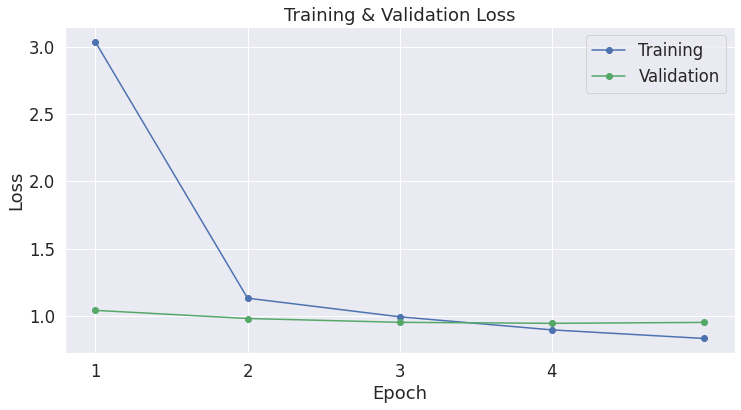

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

#output_dir = './model_save/'
output_dir = 'gdrive/MyDrive/Colab Notebooks/model_save'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#tokenizer.save_model("tokenizer")

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to gdrive/MyDrive/Colab Notebooks/model_save


('gdrive/MyDrive/Colab Notebooks/model_save/tokenizer_config.json',
 'gdrive/MyDrive/Colab Notebooks/model_save/special_tokens_map.json',
 'gdrive/MyDrive/Colab Notebooks/model_save/vocab.json',
 'gdrive/MyDrive/Colab Notebooks/model_save/merges.txt',
 'gdrive/MyDrive/Colab Notebooks/model_save/added_tokens.json')

In [ ]:
 !ls -l --block-size=K 'gdrive/MyDrive/Colab Notebooks/model_save'

total 499775K
-rw------- 1 root root      1K Jul  6 06:47 added_tokens.json
-rw------- 1 root root      1K Jul  6 06:47 config.json
-rw------- 1 root root    446K Jul  6 06:47 merges.txt
-rw------- 1 root root 498448K Jul  6 06:47 pytorch_model.bin
-rw------- 1 root root      1K Jul  6 06:47 special_tokens_map.json
-rw------- 1 root root      1K Jul  6 06:47 tokenizer_config.json
-rw------- 1 root root    878K Jul  6 06:47 vocab.json
